### Exercise 2
# Attention for Timeseries Prediction

This time we will learn how to implement attention and how it can improve prediction of timeseries data.

In [61]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

### PANJAPAN Dataset
Use `pandas` to read the PANJAPAN dataset. The dataset is organised as a directory full of CSV files, each of which contains a timeseries. Each timeseries has two values, a timestamp and a value.

In [2]:
timeseries = []

DATAPATH = "/projects/p_scads_llm_secrets/datasets/PANJAPAN/benchmarking"
for path in os.listdir(DATAPATH):
    if path.endswith(".csv") and (df := pd.read_csv(DATAPATH / path).to_numpy()).shape == (840, 2):
        timeseries.append(df)

timeseries = np.array(timeseries)
print("Length", len(timeseries))

Length 39


In [3]:
timeseries[0]

array([[1.1019200e+01, 1.5953238e+09],
       [1.1023500e+01, 1.5953274e+09],
       [1.1048700e+01, 1.5953310e+09],
       ...,
       [1.0214000e+01, 1.5983370e+09],
       [1.0202700e+01, 1.5983406e+09],
       [1.0201000e+01, 1.5983442e+09]])

### Visualize the Timeseries
Just to see what the dataset looks like, we make plots of the 

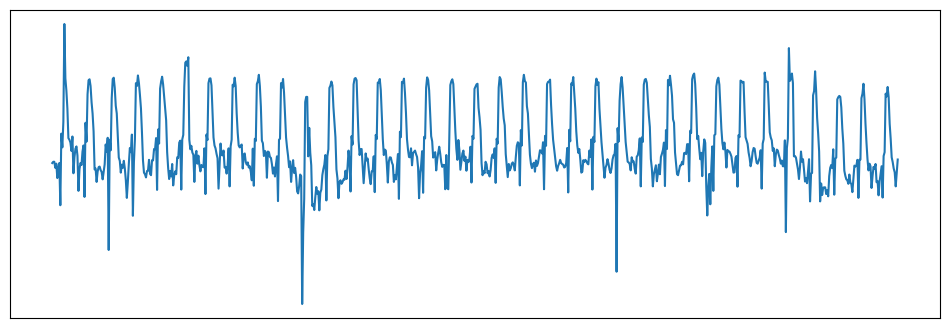

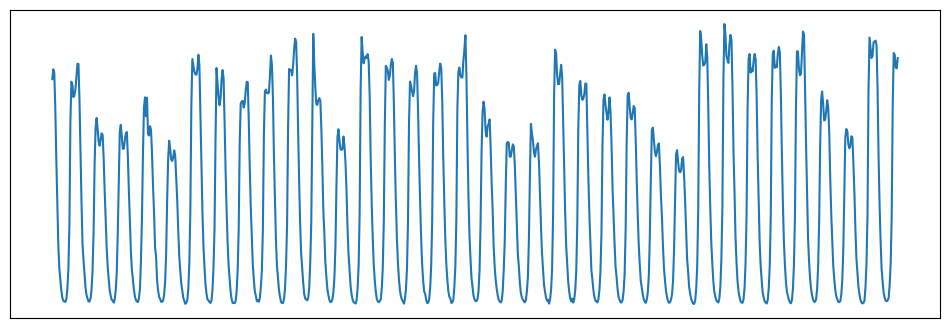

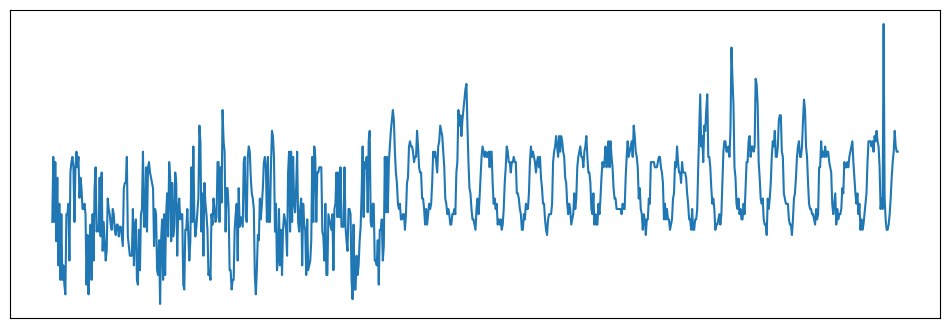

In [4]:
import matplotlib.pyplot as plt

def plot(value, timestamp):
    f = plt.figure(figsize=(12, 4))
    plt.plot(timestamp, value)
    plt.xticks([])
    plt.yticks([])
    return f

_ = plot(timeseries[15, :, 0], timeseries[15, :, 1])
_ = plot(timeseries[35, :, 0], timeseries[35, :, 1])
_ = plot(timeseries[30, :, 0], timeseries[30, :, 1])

We will now split the dataset into training, validation and testing splits.

In [65]:

from numpy.lib.stride_tricks import sliding_window_view

BACKCAST_LENGTH = 5
FORECAST_LENGTH = 2

def create_windows(series: np.ndarray):
    # Normalize
    mean = np.mean(series, axis=0)
    std = np.std(series, axis=0)
    if std[0] != 0:
        series = (series - mean) / std

    windows = sliding_window_view(series, window_shape=BACKCAST_LENGTH + FORECAST_LENGTH, axis=0).swapaxes(1, 2)
    windows = torch.tensor(windows)
    
    return windows

In [107]:
from torch.utils.data import DataLoader, random_split

# Set a seed to make experiments repeatable
torch.manual_seed(1337)

# Create three splits at 80%, 90% and 100% of the dataset
train_dataset, valid_dataset, tests_dataset = random_split(timeseries, lengths=(0.75, 0.05, 0.2))